# Rekurentne neuronske mreže i vremenske serije

Ovaj primer ilustruje rad sa rekurentnim neuronskim mrežama u analizi vremenskih serija. 

U radu će se koristiti podaci meteorološke stanice Maks Plank instituta u Jeni. U periodu od 2009. godine do 2016. godine na svakih 10 minuta merene su vrednosti 14 različitih parametara kao što su temperatura, atmosferski pritisak, vlažnost vazduha, pravac vetra i drugi. Naš zadatak će biti da osmislimo model koji će predvidjati vrednosti `temperature` u toku jednog dana na osnovu nekoliko prethodnih merenja.

Skup podataka se može preuzeti sa [ove](https://www.kaggle.com/stytch16/jena-climate-2009-2016) adrese.

Prvo ćemo učitati potrebne biblioteke.

In [1]:
import os
import numpy as np 
from matplotlib import pyplot as plt

In [3]:
from keras.preprocessing import sequence
from keras.layers import Dense, GRU
from keras.models import Sequential, load_model

In [4]:
np.random.seed(7)

## 1. korak: Učitavanje i analiza raspoloživih podataka

Podaci sa kojima ćemo raditi se nalaze u datoteci `jena_climate_2009_2016.csv` i predstavljaju regularna meranja relevantnih meteoroloških parametara.

In [5]:
data_directory = './data/'
file_name = os.path.join(data_directory, 'jena_climate_2009-2016.csv')
f = open(file_name, 'r')
data = f.read()
f.close()

Ovako pročitani podaci su u tekstualnoj formi i potrebno ih je dalje obraditi. Prvo ćemo izdvojiti linije ovog fajla.

In [6]:
all_lines = data.split('\n')
number_of_lines = len(all_lines)
number_of_lines

420552

Prva linija sadržaja je zaglavlje sa imenima kolona merenih parametara.

In [7]:
header = all_lines[0]
print(header)

"Date Time","p (mbar)","T (degC)","Tpot (K)","Tdew (degC)","rh (%)","VPmax (mbar)","VPact (mbar)","VPdef (mbar)","sh (g/kg)","H2OC (mmol/mol)","rho (g/m**3)","wv (m/s)","max. wv (m/s)","wd (deg)"


In [8]:
header = header.split(',')

In [9]:
header

['"Date Time"',
 '"p (mbar)"',
 '"T (degC)"',
 '"Tpot (K)"',
 '"Tdew (degC)"',
 '"rh (%)"',
 '"VPmax (mbar)"',
 '"VPact (mbar)"',
 '"VPdef (mbar)"',
 '"sh (g/kg)"',
 '"H2OC (mmol/mol)"',
 '"rho (g/m**3)"',
 '"wv (m/s)"',
 '"max. wv (m/s)"',
 '"wd (deg)"']

Parametara ima ukupno 15 uključujući i vreme merenja `'Date Time'`.

In [10]:
len(header)

15

Preostale linije sadržaja su linije sa podacima. 

In [11]:
lines = all_lines[1:]

In [12]:
lines[1]

'01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.40,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.10'

Podatke je dalje potrebno prebaciti u numeričku formu. Prilikom prebacivanja vrednosti ćemo ignorisati informaciju o vremenu merenja.

In [13]:
number_of_features = len(header)-1
number_of_mesurements = len(lines)
float_data = np.zeros((number_of_mesurements, number_of_features))

In [14]:
for i, line in enumerate(lines):
    values = [ float(m) for m in line.split(',')[1:]]
    float_data[i, :] = values

In [15]:
float_data.shape

(420551, 14)

Matrica sa podacima je `float_data` i dimenzija je `420551 x 14`.

Možemo prikazati kako izgleda grafik promene temeprature u ovom periodu.

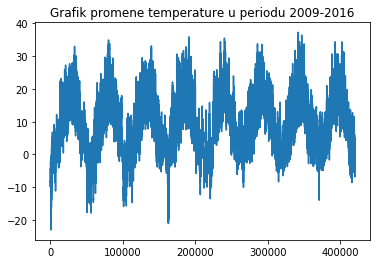

In [16]:
temp = float_data[:, 1]
plt.title('Grafik promene temperature u periodu 2009-2016')
plt.plot(range(0, len(lines)) , temp)
plt.show()

Merenja su vršena na svakih 10 minuta, tj. 6 puta u satu vremena tj. 6x24 = 144 puta u toku jednog dana. 

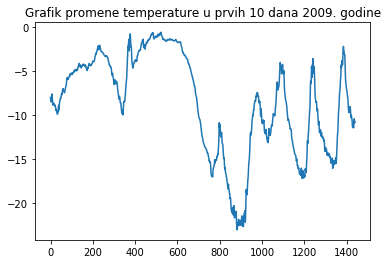

In [17]:
plt.title("Grafik promene temperature u prvih 10 dana 2009. godine")
plt.plot(range(0, 1440) , temp[0:1440])
plt.show()

Kako je potrebno kreirati model koji će predvidjati vrednosti temperature u budućnosti (za 24 sata tj. 144 vrednosti unapred), opredelićemo se za predikcije na osnovu svakog šestog merenja (jednom u satu) u protekllih 720 merenja (5 dana). Motivacija za preskakanje nekih vrednosti prethodnih merenja je nepromenljivost temperature u kratkim vremenskim periodima kao što je period od 10 minuta.

Broj prethodnih merenja ćemo obeležiti promenljivom `lookback`, a frekvenciju sa kojom će se uzimati prethodna merenja `steps`.

In [18]:
lookback = 720

In [19]:
steps = 6 

Promenljiva `delay` će predstavljati udaljenost trenutka u budućnosti u kojem treba dati ocenu temperature.

In [20]:
delay = 144 

<img src='assets/jena_dataset.jpg'>

## 2. korak: Generisanje skupova za treniranje, validaciju i testiranje

Skupovi za treniranje, validaciju i testiranje treba da sadrže vrednosti merenja sa odgovarajućim vremenskim razmakom i temperature koje su im odgovarale u trenucima u budućnosti. Da bi se održala disjunktnost ovih skupova, merenja će biti birana iz različitih opsega vrednosti određenih svojom donjom i gornjom granicom. Merenja u skupu za treniranje treba da prethode merenjima u validacionom skupa, a ona zajedno, treba da prethode merenjima u skupu za testiranje. 

Nadalje sledi funkcija koja vraća odgovarajuće generatore vrednosti. Argumenti ove funkcije su redom: 
- data: zadati podaci
- lookback: broj merenja iz prošlosti koje treba uzeti u obzir
- delay: broj merenja u budućnosti za koje treba dati ocene merenja
- min_index, max_index: vrednosti koje predstavljaju donju i gornju granicu merenja 
- shuffle: indikator mešanja podataka
- batch_size: veličina skupa podataka koje treba generisati
- step: korak sa kojim će biti birana merenja iz prošlosti

In [21]:
def generator(data, lookback, delay, min_index, max_index, shuffle = False, batch_size = 128, step = 6):       
        
        # za slucaj da max_index nije zadat, bira se vrednost koja garantuje izbor odgovarajuceg broj predikcija
        if max_index is None: 
            max_index = len(data) - delay -1
            
            
        # indeks i oznavacava minimalni indeks merenja od kojeg se mogu birati podaci za zeljeni skup 
        # izraz garantuje da postoji odgovarajuci broj merenja u proslosti
        
        i = min_index + lookback 
        
        # U smernicama Keras biblioteke za implementaciju generatorske funkcije stoji: 
        # The generator is expected to loop over its data indefinitely.
        while True: 
            
            # generise se odgovarajuci skup indeksa vrednosti merenja:
            # ukupno njih batch_size iz dozvoljenih granica
            if shuffle: 
                rows = np.random.randint(low=i, high=max_index, size=batch_size)
            else: 
                if i + batch_size >= max_index:
                    i = min_index + lookback
                rows = np.arange(i, min(i + batch_size, max_index))
                
                i += len(rows)

            # samples niz ce biti skup odgovarajucih merenja
            samples = np.zeros((len(rows), lookback//step, float_data.shape[-1]))
            
            # targets niz ce biti skup odgovarajucih predikcija 
            targets = np.zeros(len(rows))
            
            for j, row in enumerate(rows):
                indexes = range(rows[j]-lookback, rows[j], step)
                samples[j] = data[indexes]
                targets[j] = data[rows[j] + delay][1]
    
    
            # generator će generisati odgovarajuće uzorke i njihova merenja
            yield samples, targets

Fiksiraćemo broj instanci iz kojeg se bira skup za treniranje.

In [22]:
number_of_training_data = 200000

Pre treniranja izvršićemo standardizaciju podataka. 

In [23]:
mean = float_data[: number_of_training_data].mean(axis=0)
float_data -= mean
std = float_data[: number_of_training_data].std(axis=0)
float_data /= std

Fiksiraćemo i veličinu skupova koje treba generisati.

In [24]:
batch_size = 32

Zatim ćemo pozivom implementirane funkcije kreirati redom generatore skupa za treniranje, skup za validaciju i skup za testiranje.

In [25]:
train_gen = generator(float_data, lookback, delay, min_index = 0, max_index = 200000, shuffle = True, batch_size = batch_size, step = steps)
val_gen = generator(float_data, lookback, delay, min_index = 200001, max_index = 300001, shuffle = True, batch_size = batch_size, step = steps)
test_gen = generator(float_data, lookback, delay, min_index = 300001, max_index=None, shuffle = True, batch_size = batch_size, step = steps)

U skladu sa korišćenim granicama, odredićemo i broj validacionih i test koraka.

In [26]:
val_steps = (300000 - 200001 - lookback) // batch_size
test_steps = (len(float_data) - 300001 - lookback) // batch_size

## 3. korak: Kreiranje i treniranje mreže

Naša mreža za predikciju temperature će sadržati jedan rekurentni sloj GRU ćelija veličine 32 sa podrazumevanom hiperboličkom aktivacijom i jedan gusti sloj sa jednom ćelijom (jer mreža radi predikciju temperature) i linearnom aktivacijom.  

In [27]:
model = Sequential()
model.add(GRU(32, input_shape = (None, float_data.shape[-1])))
model.add(Dense(1))

Instructions for updating:
Colocations handled automatically by placer.


In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_1 (GRU)                  (None, 32)                4512      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 33        
Total params: 4,545
Trainable params: 4,545
Non-trainable params: 0
_________________________________________________________________


Mreža će koristiti optimizator RMSProp i srednju apsolutnu grešku kao funkciju gubitka. 

In [29]:
model.compile(optimizer='rmsprop', loss='mae')

Mrežu ćemo obučavati koristeći metodu `fit_generator` koja je ekvivalentna `fit` metodi uz izuzetak korišćenja generatorskih funkcija za kreiranje paketića za treniranje. Argumentom `steps_per_epoch` se kontroliše koliko obrađenih paketića traje jedna epoha. Ova metoda koristi generatorske funkcije i za kreiranje paketića za validaciju. Argument `validation_steps` kontroliše koliko validacionih paketića treba generisati na nivou jedne epohe. 

Više o ovoj funkciji  možete pronaći i u [zvaničnoj dokumentaciji](https://keras.io/models/sequential/#fit_generator).

Mrežu ćemo trenirati 20 epoha koristeći 500 paketića po epohi. Treniranje mreže može da potraje nešto duže. 

In [30]:
epochs = 20
steps_per_epoch=500

In [71]:
history = model.fit_generator(train_gen, steps_per_epoch=steps_per_epoch, epochs=epochs, \
                              validation_data=val_gen, validation_steps=val_steps)

Epoch 1/20
500/500 [==============================] - 100s 200ms/step - loss: 7.2288 - val_loss: 6.1050
Epoch 2/20
500/500 [==============================] - 94s 189ms/step - loss: 5.0227 - val_loss: 4.5312
Epoch 3/20
500/500 [==============================] - 97s 194ms/step - loss: 4.1254 - val_loss: 2.8570
Epoch 4/20
500/500 [==============================] - 83s 166ms/step - loss: 3.6953 - val_loss: 3.2032
Epoch 5/20
500/500 [==============================] - 83s 166ms/step - loss: 3.5370 - val_loss: 3.2545
Epoch 6/20
500/500 [==============================] - 84s 168ms/step - loss: 3.3565 - val_loss: 2.6826
Epoch 7/20
500/500 [==============================] - 84s 168ms/step - loss: 3.2878 - val_loss: 3.6039
Epoch 8/20
500/500 [==============================] - 82s 164ms/step - loss: 3.2575 - val_loss: 2.8407
Epoch 9/20
500/500 [==============================] - 83s 165ms/step - loss: 3.2680 - val_loss: 2.3003
Epoch 10/20
500/500 [==============================] - 84s 168ms/step - 

Model ćemo sačuvati u ovoj formi tako da može da posluži za dalje analize i ispitivanja. 

In [31]:
# model.save('models/jena_model.h5')

In [32]:
# model = load_model('models/jena_model.h5')

Nacrtaćemo i grafik gubitka funkcije na skupu za treniranje i skupu za validaciju.

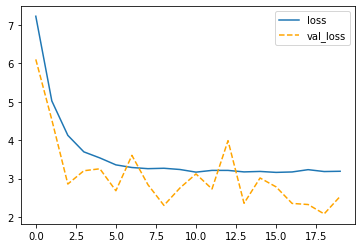

In [81]:
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(0, epochs)
plt.plot(epochs_range, loss, label ='loss')
plt.plot(epochs_range, val_loss, label='val_loss', linestyle ='--', color='orange')
plt.legend(loc='best')
plt.show()

Po formi dobijenih vrednosti funkcija gubitka se primerćuje da mreža uči, ali su vrednosti greške koje se dobijaju dosta velike pa bi imalo smisla probati sa nešto dužim treniranjem i predloženim popravkama iz sekcije za vežbu. 

In [82]:
min_val_loss = np.min(val_loss)
print(min_val_loss)

2.078561305999756


Najmanja greška na validacionom skupu je oko 2.078. 

## 4. korak: Evaluacija

Za evaluaciju modela se može iskoristiti funkcija `evaluate_generator`. Ova funkcija radi slično drugim `evaluate` funkcijama tj. predviđa vrednosti i upoređuje ih sa pravim vrednostima koristeći metrike modela. Za generisanje paraova test instanci i njihovih vrednosti oblika `(samples, targets)` koristićemo `test_gen` generator.

In [41]:
model.evaluate_generator(test_gen, steps=test_steps)

6.835853099822998

In [39]:
model.metrics_names

['loss']

I ova vrednost funkcije gubitka (srednje apsolutne greške) ukazuje da model treba još unapređivati.

### Zadaci za vežbu:

* Kako se ponaša mreža ukoliko se doda `recurrent_dropout` argument sa vrednošću 0.2 GRU sloju?

* Uporediti dobijene rezultate sa rezultatima koje generiše mreža sa propagacijom unapred čiji su ulazi prethodna merenja (njih lookback//steps), a koja ima jedan gusti sloj veličine 32 neurona i izlazni gusti sloj sa jednim neuronom koji daje vrednost temperature.  

* Uporediti dobijene rezultate sa mrežom koja umesto GRU sloja koristi LSTM sloj.

### Korisni linkovi:

* Python podsetnik na generatore: https://wiki.python.org/moin/Generators
* Github repozitorijum Fransoa Šolea (autora Kerasa) sa još nekim modifikacijama i unapređenjima ovog primera: https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/6.3-advanced-usage-of-recurrent-neural-networks.ipynb